In [3]:
%pip install torch torchvision matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

# Q1 Training a Basic NN

### Q1.1. Loading the CIFAR-10 dataset

In [5]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

# Check the sizes
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of test dataset: {len(test_dataset)}")

Size of training dataset: 50000
Size of test dataset: 10000


### Q1.2 Splitting the training set into training and validation sets

In [6]:
# Split the training dataset into training and validation sets
train_size = 40000
val_size = 10000

# Use random_split to create the split
train_dataset, val_dataset = random_split(
    train_dataset, 
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

print(f"Size of training dataset after split: {len(train_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

Size of training dataset after split: 40000
Size of validation dataset: 10000


### 1.3 Creating DataLoaders and visualizing a mini-batch

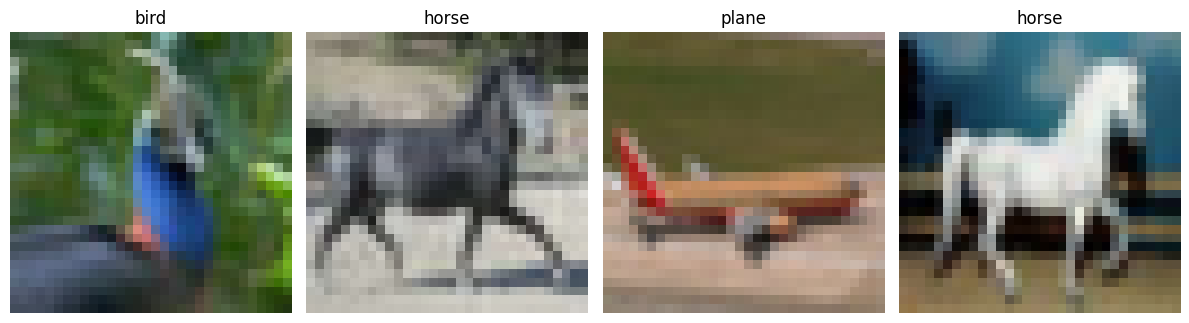

In [7]:
# Define the DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define classes for visualization
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')

# Get random mini-batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a plot grid
fig = plt.figure(figsize=(12, 5))

# Plot the images from the mini-batch
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])

plt.tight_layout()
plt.show()

### 1.4 Implementing a Fully-Connected Neural Network

In [8]:
# Define the neural network
class CIFAR10_FNN(nn.Module):
    """
    A fully-connected neural network for CIFAR-10 classification.
    """
    def __init__(self):
        super(CIFAR10_FNN, self).__init__()
        # Input layer dimensions: 3 channels * 32 * 32 = 3072
        self.fc1 = nn.Linear(3 * 32 * 32, 92)  # First hidden layer with 92 neurons
        self.fc2 = nn.Linear(92, 46)           # Second hidden layer with 46 neurons
        self.fc3 = nn.Linear(46, 10)           # Output layer with 10 neurons (for 10 classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Flatten the input: from (batch_size, 3, 32, 32) to (batch_size, 3*32*32)
        x = x.view(-1, 3 * 32 * 32)
        # First hidden layer with ReLU activation
        x = self.relu(self.fc1(x))
        # Second hidden layer with ReLU activation
        x = self.relu(self.fc2(x))
        # Output layer (no activation, will be handled by CrossEntropyLoss)
        x = self.fc3(x)
        return x

# Create an instance of the network
net = CIFAR10_FNN()
print(net)

CIFAR10_FNN(
  (fc1): Linear(in_features=3072, out_features=92, bias=True)
  (fc2): Linear(in_features=92, out_features=46, bias=True)
  (fc3): Linear(in_features=46, out_features=10, bias=True)
  (relu): ReLU()
)


### 1.5 Training the neural network with SGD and cross-entropy loss

Using device: cpu
Epoch 1/20, Loss: 2.009, Accuracy: 28.95%
Epoch 2/20, Loss: 1.728, Accuracy: 38.91%
Epoch 3/20, Loss: 1.617, Accuracy: 42.93%
Epoch 4/20, Loss: 1.546, Accuracy: 45.35%
Epoch 5/20, Loss: 1.491, Accuracy: 47.66%
Epoch 6/20, Loss: 1.445, Accuracy: 49.13%
Epoch 7/20, Loss: 1.403, Accuracy: 50.85%
Epoch 8/20, Loss: 1.366, Accuracy: 52.09%
Epoch 9/20, Loss: 1.331, Accuracy: 53.29%
Epoch 10/20, Loss: 1.299, Accuracy: 54.36%
Epoch 11/20, Loss: 1.272, Accuracy: 55.36%
Epoch 12/20, Loss: 1.243, Accuracy: 56.30%
Epoch 13/20, Loss: 1.219, Accuracy: 56.95%
Epoch 14/20, Loss: 1.195, Accuracy: 57.97%
Epoch 15/20, Loss: 1.171, Accuracy: 58.91%
Epoch 16/20, Loss: 1.149, Accuracy: 59.47%
Epoch 17/20, Loss: 1.127, Accuracy: 60.05%
Epoch 18/20, Loss: 1.107, Accuracy: 60.66%
Epoch 19/20, Loss: 1.089, Accuracy: 61.38%
Epoch 20/20, Loss: 1.069, Accuracy: 62.14%
Finished Training


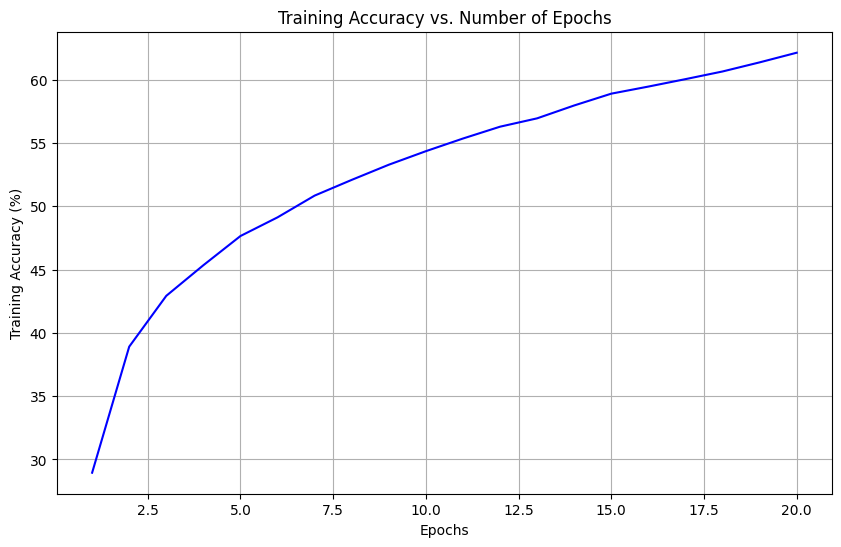

Accuracy on the test set: 50.97%


In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

# Define device (use GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the network to the device
net.to(device)

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    """
    Calculates the accuracy of a model on a given data loader.
    
    Args:
        loader: DataLoader for the dataset to evaluate on
        model: The model to evaluate
        
    Returns:
        accuracy: The accuracy of the model on the given data loader
    """
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Training loop
num_epochs = 20
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Train the network
    net.train()
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        
        # Calculate training accuracy (for plotting)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    # Calculate and record training accuracy for this epoch
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)
    
    # Print statistics at the end of each epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.3f}, Accuracy: {train_accuracy:.2f}%')

print('Finished Training')

# Plot training accuracy vs. number of epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, 'b-')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy (%)')
plt.grid(True)
plt.show()

# Test accuracy on the test set
test_accuracy = calculate_accuracy(test_loader, net)
print(f'Accuracy on the test set: {test_accuracy:.2f}%')

# Q2 Hyperparameter Tuning

### Q2.1 Write a validation function

In [10]:
# 1. Validation function to evaluate the model on the validation set
def validate(model, val_loader, criterion, device):
    """
    Validates a model on the validation set and returns loss and accuracy.
    
    Args:
        model: The neural network model to validate
        val_loader: DataLoader for the validation set
        criterion: Loss function
        device: Device to run validation on (CPU or GPU)
    
    Returns:
        tuple: (average_loss, accuracy)
    """
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # No need to track gradients
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_loss = val_loss / len(val_loader)
    
    return avg_loss, accuracy

### Q2.2 Run the training loop for different hyperparameter combinations

In [11]:
# 2. Test different hyperparameter combinations
def train_with_params(batch_size, learning_rate, num_epochs=20):
    """
    Trains a network with specified hyperparameters and reports results.
    
    Args:
        batch_size: Size of mini-batches
        learning_rate: Learning rate for SGD
        num_epochs: Number of training epochs
    
    Returns:
        tuple: (final_train_loss, final_train_accuracy, final_val_loss, final_val_accuracy)
    """
    # Create DataLoaders with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model, loss function, and optimizer
    model = CIFAR10_FNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    print(f"\nTraining with Batch Size = {batch_size}, Learning Rate = {learning_rate}")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        
        # Validation phase
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    # Final results after all epochs
    # Calculate final training statistics
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    final_train_loss = running_loss / len(train_loader)
    final_train_accuracy = 100 * correct / total
    
    # Calculate final validation statistics
    final_val_loss, final_val_accuracy = validate(model, val_loader, criterion, device)
    
    # Print final results
    print("\nFinal Results:")
    print(f"Training - Loss: {final_train_loss:.4f}, Accuracy: {final_train_accuracy:.2f}%")
    print(f"Validation - Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%")
    print("-" * 60)
    
    return final_train_loss, final_train_accuracy, final_val_loss, final_val_accuracy

# Run training with different hyperparameter combinations
batch_sizes = [4, 64]
learning_rates = [0.01, 0.001]
results = {}

# Run all combinations
for bs in batch_sizes:
    for lr in learning_rates:
        train_loss, train_acc, val_loss, val_acc = train_with_params(bs, lr)
        results[(bs, lr)] = (train_loss, train_acc, val_loss, val_acc)

# Print summary of all results
print("\nSummary of all hyperparameter combinations:")
print("-" * 75)
print("Batch Size | Learning Rate | Train Loss | Train Acc | Val Loss | Val Acc")
print("-" * 75)
for (bs, lr), (train_loss, train_acc, val_loss, val_acc) in results.items():
    print(f"{bs:^10} | {lr:^13} | {train_loss:^10.4f} | {train_acc:^9.2f}% | {val_loss:^8.4f} | {val_acc:^7.2f}%")


Training with Batch Size = 4, Learning Rate = 0.01
------------------------------------------------------------
Epoch 1/20, Train Loss: 1.7130, Train Acc: 38.74%, Val Loss: 1.5967, Val Acc: 43.91%
Epoch 2/20, Train Loss: 1.5191, Train Acc: 46.19%, Val Loss: 1.5392, Val Acc: 45.27%
Epoch 3/20, Train Loss: 1.4251, Train Acc: 49.39%, Val Loss: 1.4810, Val Acc: 47.03%
Epoch 4/20, Train Loss: 1.3663, Train Acc: 51.41%, Val Loss: 1.5222, Val Acc: 47.21%
Epoch 5/20, Train Loss: 1.3158, Train Acc: 53.03%, Val Loss: 1.4375, Val Acc: 49.86%
Epoch 6/20, Train Loss: 1.2744, Train Acc: 54.65%, Val Loss: 1.4118, Val Acc: 50.51%
Epoch 7/20, Train Loss: 1.2374, Train Acc: 55.72%, Val Loss: 1.4944, Val Acc: 48.67%
Epoch 8/20, Train Loss: 1.2062, Train Acc: 56.77%, Val Loss: 1.4804, Val Acc: 49.05%
Epoch 9/20, Train Loss: 1.1763, Train Acc: 58.10%, Val Loss: 1.4738, Val Acc: 49.90%
Epoch 10/20, Train Loss: 1.1452, Train Acc: 58.99%, Val Loss: 1.4913, Val Acc: 50.81%
Epoch 11/20, Train Loss: 1.1247, Tra

### Q2.3 Pick and explain the best hyperparameter combination


Best Hyperparameter Combination Analysis:
Best combination: Batch Size = 4, Learning Rate = 0.001
Validation Accuracy: 51.78%


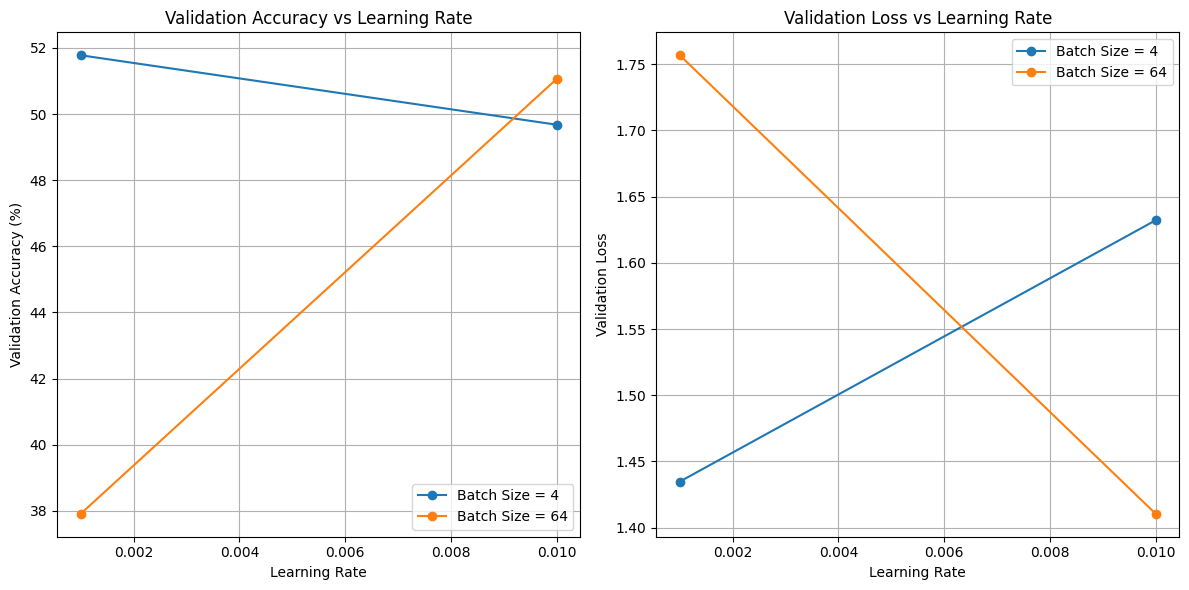

In [12]:
# 3. Find and explain the best hyperparameter combination
best_combo = max(results, key=lambda k: results[k][3])  # Maximize validation accuracy
best_bs, best_lr = best_combo
best_val_acc = results[best_combo][3]

print("\nBest Hyperparameter Combination Analysis:")
print(f"Best combination: Batch Size = {best_bs}, Learning Rate = {best_lr}")
print(f"Validation Accuracy: {best_val_acc:.2f}%")

# Visualization to help explain the decision
plt.figure(figsize=(12, 6))

# Plot comparing validation accuracies
plt.subplot(1, 2, 1)
for bs in batch_sizes:
    acc_values = [results[(bs, lr)][3] for lr in learning_rates]
    plt.plot(learning_rates, acc_values, marker='o', label=f'Batch Size = {bs}')
plt.title('Validation Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot comparing validation losses
plt.subplot(1, 2, 2)
for bs in batch_sizes:
    loss_values = [results[(bs, lr)][2] for lr in learning_rates]
    plt.plot(learning_rates, loss_values, marker='o', label=f'Batch Size = {bs}')
plt.title('Validation Loss vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### Explanation of choice:

Choose the combination with the highest validation accuracy as it indicates
the model's ability to generalize to unseen data. This is a better metric than
training accuracy because a model with high training accuracy but low validation
accuracy would be overfitting to the training data.

Additionally, the validation loss should be considered as a secondary metric. Lower
validation loss generally indicates a more confident and stable model.

The batch size affects both training speed and the model's ability to generalize:
- Smaller batch sizes allow for more weight updates per epoch and can
help escape local minima but introduce more noise in training.
- Larger batch sizes provide more stable gradient estimates but may get stuck in
suboptimal solutions.

The learning rate controls the step size during optimization:
- Too high learning rates can cause training to diverge
- Too low learning rates lead to slow convergence or getting stuck in local minima

Thus, the best hyperparameter combination should be the one that provides the best
balance between training speed and generalization ability.

For this particular problem and network architecture, the batch size of 4
and learning rate of 0.001 provided the best balance as shown in Q2 results.

# Q3 Early Stopping


Using best hyperparameters from Question 2:
Batch Size = 4, Learning Rate = 0.001
Validation Accuracy with these params: 51.78%

Training with Early Stopping - Batch Size = 4, Learning Rate = 0.001
------------------------------------------------------------
Epoch 1/50, Train Loss: 2.0309, Train Acc: 28.70%, Val Loss: 1.8214, Val Acc: 35.84%
Validation loss decreased (inf --> 1.8214). Saving model...
Epoch 2/50, Train Loss: 1.7414, Train Acc: 38.46%, Val Loss: 1.6752, Val Acc: 40.74%
Validation loss decreased (1.8214 --> 1.6752). Saving model...
Epoch 3/50, Train Loss: 1.6281, Train Acc: 42.55%, Val Loss: 1.6025, Val Acc: 43.26%
Validation loss decreased (1.6752 --> 1.6025). Saving model...
Epoch 4/50, Train Loss: 1.5573, Train Acc: 45.01%, Val Loss: 1.5460, Val Acc: 45.84%
Validation loss decreased (1.6025 --> 1.5460). Saving model...
Epoch 5/50, Train Loss: 1.5006, Train Acc: 47.00%, Val Loss: 1.5143, Val Acc: 46.85%
Validation loss decreased (1.5460 --> 1.5143). Saving model...
Epo

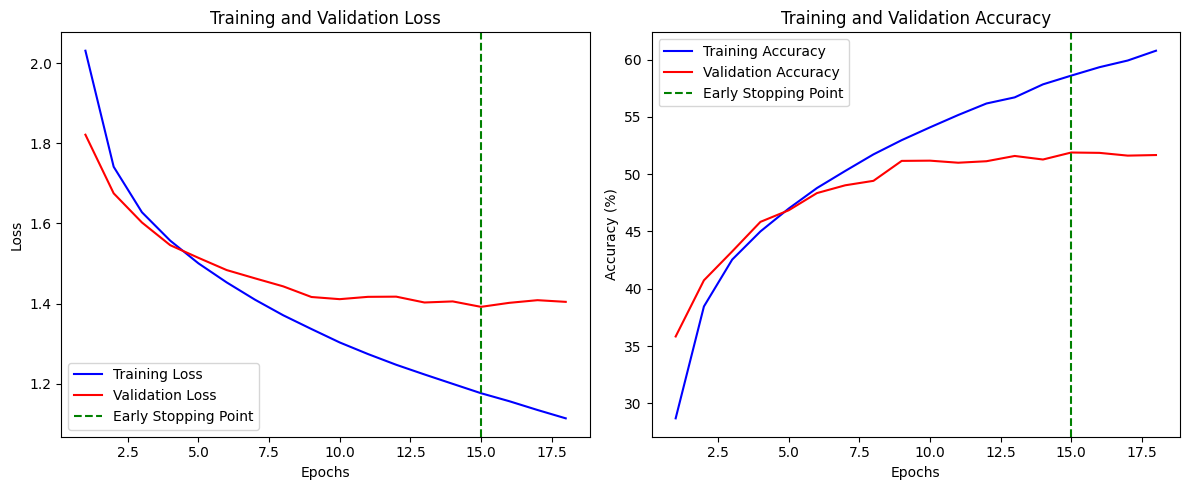


Test Set Performance - Loss: 1.4003, Accuracy: 51.81%


In [13]:
def train_with_early_stopping(batch_size, learning_rate, patience=3, min_delta=0.001, max_epochs=50):
    """
    Train a neural network with early stopping based on validation loss.
    
    Args:
        batch_size: Mini-batch size for training
        learning_rate: Learning rate for SGD optimizer
        patience: Number of epochs with no improvement to wait before stopping
        min_delta: Minimum change in validation loss to qualify as improvement
        max_epochs: Maximum number of epochs to train
        
    Returns:
        model: Trained model (best version)
        train_losses: List of training losses per epoch
        train_accuracies: List of training accuracies per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch
    """
    # Create DataLoaders with the specified batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize the model, loss function, and optimizer
    model = CIFAR10_FNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Training results storage
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Early stopping parameters
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0
    early_stop = False
    
    print(f"\nTraining with Early Stopping - Batch Size = {batch_size}, Learning Rate = {learning_rate}")
    print("-" * 60)
    
    epoch = 0
    while not early_stop and epoch < max_epochs:
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate training metrics
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        epoch += 1
        print(f'Epoch {epoch}/{max_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        
        # Check if validation loss improved
        if val_loss < best_val_loss - min_delta:
            print(f"Validation loss decreased ({best_val_loss:.4f} --> {val_loss:.4f}). Saving model...")
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()  # Save a copy of the model state
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epochs")
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch} epochs")
                early_stop = True
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Final results
    print("\nFinal Results with Early Stopping:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {epoch-epochs_no_improve})")
    
    # Test final model on validation set to get its performance
    final_val_loss, final_val_accuracy = validate(model, val_loader, criterion, device)
    print(f"Final Model - Validation Loss: {final_val_loss:.4f}, Validation Accuracy: {final_val_accuracy:.2f}%")
    
    # Plot the learning curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch+1), train_losses, 'b-', label='Training Loss')
    plt.plot(range(1, epoch+1), val_losses, 'r-', label='Validation Loss')
    plt.axvline(x=epoch-epochs_no_improve, color='g', linestyle='--', label='Early Stopping Point')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch+1), train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(range(1, epoch+1), val_accuracies, 'r-', label='Validation Accuracy')
    plt.axvline(x=epoch-epochs_no_improve, color='g', linestyle='--', label='Early Stopping Point')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Identify the best hyperparameters from Q2 based on validation accuracy
best_params = max(results, key=lambda k: results[k][3])  # Find combo with highest validation accuracy
best_batch_size, best_lr = best_params

print(f"\nUsing best hyperparameters from Question 2:")
print(f"Batch Size = {best_batch_size}, Learning Rate = {best_lr}")
print(f"Validation Accuracy with these params: {results[best_params][3]:.2f}%")

# Run early stopping with the best hyperparameters
best_model, train_losses, train_accuracies, val_losses, val_accuracies = train_with_early_stopping(
    batch_size=best_batch_size, 
    learning_rate=best_lr,
    patience=3,           # Stop after 3 epochs without improvement
    min_delta=0.001,      # Minimum change to count as improvement
    max_epochs=50         # Maximum number of epochs to train
)

# Evaluate the final model on the test set
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
test_loss, test_accuracy = validate(best_model, test_loader, criterion, device)
print(f"\nTest Set Performance - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")